### Verifying the forecasting of a time series

In [22]:
## Fault Injection
import numpy as np
import pandas as pd
from numpy import array
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
from random import randint
# from random import random
import random
import math



# def randomised(data):
#     n = len(data)
#     fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
#     for col in data.columns:
        
#         for i in range(len(data)):
#             p = random.random()
#             if p > 0.5:
#                 data[col].iloc[i] += random.choice(fault_units)

#     return data


def value_flip(data, loc, col):
    for dp in data.index[loc]:
        if(data.loc[dp, col] == 1):
            data.loc[dp, col] = 0
        else:
            data.loc[dp, col] = 1            
    return data


def stuck_at(data, loc, col, val):
    # This is either stuck_at zero or at 1
    for dp in data.index[loc]:
        data.loc[dp, col] = val
    return data

def insert_outlier(data, loc, col):
#     // This inserts at the beginning of the data
    thresh = random.uniform(0.5, 1.5)
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    high_outlier = q3 + 1.5*iqr
    low_outlier = q1 - 1.5*iqr - thresh
    for dp in data.index[loc]:
        data.loc[dp, col] =high_outlier + random.uniform(0.5, 1.5)
#         data.loc[dp, col] =low_outlier - random.uniform(0.5, 1.5)
    return data


def stuck2_at(data, val, col, loc="beg"):
    # This is either stuck_at zero or at 1
    if(loc == "beg"):
        n = math.floor(len(data[col])*0.3)
        for i in range(n):
            data[col][i] = val
    return data

# mydata = read_csv('simulated_waterTank.csv', header=0, index_col=0, skiprows=4)
mydata = read_csv('waterTankNew.csv', header=0, index_col=0)

faulty_data = stuck_at(mydata, range(500,700), "Tank1InFlow", 1)
faulty_data.to_csv('stuck_at_faulty_data.csv')

faulty_data = stuck_at(mydata, range(500,700), "Tank1InFlow", 0)
faulty_data.to_csv('stuck_at_zero_faulty_data.csv')


faulty_data_vf = value_flip(mydata, range(500,700), "Tank1InFlow")
faulty_data_vf.to_csv('value_flip_faulty_data.csv')

faulty_data_outlier = insert_outlier(mydata, range(500,700), "Tank1InFlow")
faulty_data_outlier.to_csv('outlier_faulty_data.csv')
# faulty_data.head()
# mydata

print("Files saved successfully")

Files saved successfully


### Prediction with faulty data (stuck_at)

In [16]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('stuck_at_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  7.28%
Prediction is successful!


### Prediction with faulty data (value_flip)

In [17]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('value_flip_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  7.60%
Prediction is successful!


### Prediction with faulty data (Outlier)

In [21]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('outlier_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  6.88%
Prediction is successful!


### Prediction with faulty data (Stuck_at_zero)

In [23]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('stuck_at_zero_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  7.60%
Prediction is successful!


# Second Model

### Prediction with faulty data (stuck_at_one)

In [24]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm2.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('stuck_at_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  8.56%
Prediction is successful!


### Prediction with faulty data (Value_flip)

In [26]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm2.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('value_flip_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  8.56%
Prediction is successful!


### Prediction with faulty data (outlier)

In [27]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm2.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('outlier_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  7.02%
Prediction is successful!


### Prediction with faulty data (Stuck_at_zero)

In [28]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm2.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('stuck_at_zero_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  8.60%
Prediction is successful!


### Third Model

### Prediction with faulty data (stuck_at)

In [30]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm3.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('stuck_at_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  8.01%
Prediction is successful!


### Prediction with faulty data (value_flip)

In [31]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm3.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('value_flip_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  8.01%
Prediction is successful!


### Prediction with faulty data (outlier)

In [32]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm3.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('outlier_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  6.88%
Prediction is successful!


### Prediction with faulty data (stuck_at_zero)

In [33]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
s_model = load_model('Enc-Dec-lstm3.h5')

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


data = read_csv('stuck_at_zero_faulty_data.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
f_scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
# dataset = f_scaled_data[0:n_train,:]


new_data = f_scaled_data[0:2000,:]

# choose a number of time steps
n_steps_in, n_steps_out = 50, 100

# convert into input/output
test_X, test_y = split_sequences(new_data, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = test_X.shape[2]

score = s_model.evaluate(test_X, test_y, verbose=0)
test_yhat = s_model.predict(test_X, verbose=0)
print("%s:  %.2f%%" % (s_model.metrics_names[0], score*100))

print("Prediction is successful!")

The shape of the raw_data before scaling is (20001, 5)
loss:  8.26%
Prediction is successful!


### Test with Test functions

The shape of the raw_data before scaling is (1120, 4)
Epoch 1/70
27/27 - 3s - loss: 0.2528 - 3s/epoch - 125ms/step
Epoch 2/70
27/27 - 2s - loss: 0.1355 - 2s/epoch - 58ms/step
Epoch 3/70
27/27 - 2s - loss: 0.1297 - 2s/epoch - 65ms/step
Epoch 4/70
27/27 - 1s - loss: 0.1273 - 1s/epoch - 52ms/step
Epoch 5/70
27/27 - 2s - loss: 0.1246 - 2s/epoch - 66ms/step
Epoch 6/70
27/27 - 2s - loss: 0.1204 - 2s/epoch - 63ms/step
Epoch 7/70
27/27 - 1s - loss: 0.1113 - 1s/epoch - 49ms/step
Epoch 8/70
27/27 - 1s - loss: 0.1173 - 1s/epoch - 52ms/step
Epoch 9/70
27/27 - 1s - loss: 0.0682 - 1s/epoch - 53ms/step
Epoch 10/70
27/27 - 1s - loss: 0.0433 - 1s/epoch - 53ms/step
Epoch 11/70
27/27 - 2s - loss: 0.0318 - 2s/epoch - 61ms/step
Epoch 12/70
27/27 - 2s - loss: 0.0228 - 2s/epoch - 56ms/step
Epoch 13/70
27/27 - 2s - loss: 0.0165 - 2s/epoch - 66ms/step
Epoch 14/70
27/27 - 2s - loss: 0.0120 - 2s/epoch - 56ms/step
Epoch 15/70
27/27 - 2s - loss: 0.0187 - 2s/epoch - 56ms/step
Epoch 16/70
27/27 - 2s - loss: 0.0101 -

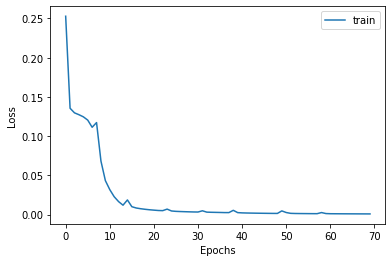

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30)                4200      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 100, 30)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 100, 30)           7320      
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 4)           124       
 tributed)                                                       
                                                                 
Total params: 11,644
Trainable params: 11,644
Non-trainable params: 0
_________________________________________________________________
Model saved!


In [37]:
# multivariate output stacked lstm example
import pandas as pd
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Bidirectional, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np



# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
# data = read_csv('waterTank.csv', header=0, index_col=0)
# data = read_csv('outputs.csv', header=0, index_col=0)
# data = read_csv('trig.csv', header=0, index_col=0)
data = read_csv('trig.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 1000
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
# n_steps_in, n_steps_out = 50, 100
n_steps_in, n_steps_out = 50, 100

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(30, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(30, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(n_features)))
# model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=70, verbose=2, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

#save the model to disk
model.save('Enc-Dec-lstm-with-Trig.h5')
print("Model saved!")

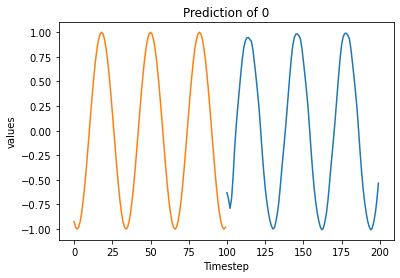

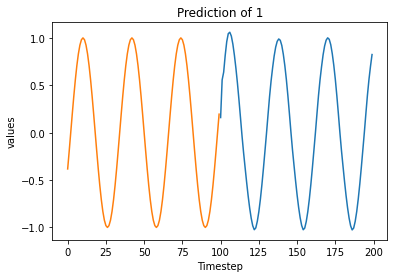

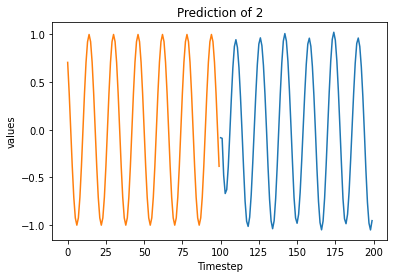

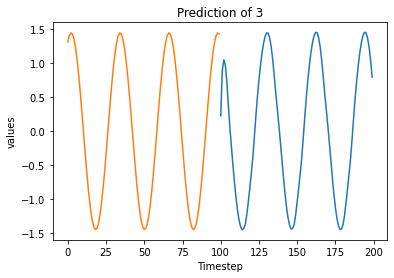

In [44]:
attr = len(inv_yhat.T)
# attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
for i in range(attr):
    title = "Prediction of "+str(i)
    actual = raw_data[950:1050,i]
    pred = inv_yhat.T
    pred_df = pd.DataFrame(inv_yhat)
    # specify the range based on the length of predicted output
    index = pd.Index(list(range(100,200)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("values")
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i])
    plt.plot(actual)
    plt.show()